# 🎥 Exploration 7 Main Project : 네이버 영화리뷰 감성분석 🎥

## ✨ 프로젝트 목표 ✨
1. 3가지 이상의 모델을 활용하여 Text Classification Task를 구현할 수 있다.
2. gensim의 유사단어 찾기를 활용하여 자체 혹은 사전 학습된 임베딩 레이어를 분석할 수 있다.
3. 한국어 Word2Vec을 활용하여 감성분석의 validation 정확도 85% 이상이 되도록 설정할 수 있다.

## ✨ 프로젝트 참고 데이터 ✨
- 이번 프로젝트는 네이버 영화에 달린 댓글들을 모아 구성된 **Naver sentiment movie corpus** 이다.
- AIFFEL 클라우드 환경에서는 **심볼릭 링크**를 걸어줌으로서 별도의 데이터 다운로드를 시도하지 않고 진행한다.

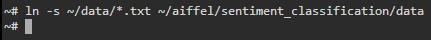

## ✨ 데이터 준비하고 확인하기 ✨
- 감성분석에 필요한 라이브러리를 import 한다.
- 감성분석에 필요한 훈련 데이터와 테스트 데이터를 준비, 확인한다.

In [1]:
# 필요한 라이브러리 import
import glob
import os
import re
import numpy as np
import pandas as pd

from collections import Counter

import urllib.request
from konlpy.tag import Okt, Mecab

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant

from gensim.models import KeyedVectors
import gensim
from sklearn.model_selection import train_test_split

from keras.layers import Bidirectional, LSTM, GRU, Dense, Conv1D
from keras.layers import Embedding, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 훈련 데이터, 테스트 데이터 준비
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [2]:
# 훈련 데이터 살펴보기
train_data.head(6)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0


In [3]:
# 테스트 데이터 살펴보기
test_data.head(6)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
5,7898805,"음악이 주가 된, 최고의 음악영화",1


## ✨ 데이터 로더 구성하기 ✨
- 프로젝트에서 다루는 Naver sentiment movie corpus 데이터에 속한 텍스트는 **가공되지 않은 상태**이다.
- 데이터 로더를 구성하는 절차는 Exploration 연습 과정에서 사용했던 **imdb.data_loader() 메소드와 동일하게 동작**하도록 설정하는 절차이다. **data_loader 안에서는 다음을 수행할 수 있다.**

1. 중복되는 데이터 제거
2. NaN으로 대응되는 결측치 제거
3. 한국어 토크나이저로 토큰화
4. Stopwords 즉, 불용어로 불리는 단어 제거
5. 사전 word_to_index 구성
6. 텍스트 스트링을 사전의 index 스트링으로 변환
7. 위의 과정을 통해 X_train, y_train, X_test, y_test, word_to_index를 리턴

- 이번 프로젝트에서는 노드에서 소개된 데이터 로더 구성 관련 코드를 활용한다.

In [4]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

- 훈련 데이터, 테스트 데이터의 길이를 살펴보고 word_to_index의 길이와 자료형을 살핀다.

In [5]:
print(len(X_train)) 
print(len(y_train)) 
print('-'*12)
print(len(X_test))
print(len(y_test))
print('-'*36)
print('word_to_index : ',len(word_to_index), type(word_to_index))

146182
146182
------------
49157
49157
------------------------------------
word_to_index :  9997 <class 'dict'>


- word_to_index에는 어떤 내용이 들어있는지 확인한다.
- word_to_index는 **word:index** 형태로 묶인 데이터들의 집합이다.
- 파이썬 프로그래밍의 index는 0부터 시작이다.
- 확인해 보면, 앞쪽에 있어야 할 **PAD, BOS, UNK가 나타나지 않았음**을 알 수 있다. 이들을 각각 **index 0, 1, 2로 대응**시켜 딕셔너리에 포함시킨다.

In [6]:
word_to_index

{'': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시간': 95,
 '지루': 96,
 '중': 97,
 '재미있': 98,
 '년': 

In [7]:
word_to_index["<PAD>"] = 0  # 패딩
word_to_index["<BOS>"] = 1  # 모든 문장의 시작
word_to_index["<UNK>"] = 2  # Unknown을 의미

- **인덱스:단어**(키:값) 형태의 딕셔너리 생성

In [8]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [9]:
# 문장 1개를 활용할 딕셔너리와 함께 주면 단어 인덱스 리스트 벡터로 변환해 주는 함수 
# 모든 문장은 <BOS>로 시작하도록 설정
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode해 주는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## ✨ 모델 구성을 위한 데이터 분석 및 가공 ✨
- 데이터셋 내의 문장의 길이 분포 확인
- 최대 문장 길이를 적절하게 지정
- keras.preprocessing.sequence.pad_sequences를 활용한 패딩

In [10]:
total_data_text = list(X_train) + list(X_test)
# 텍스트 데이터 문장 길이의 리스트 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장 길이의 평균값, 최대값, 표준편차 각각 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}% 정도가 maxlen 설정값 이내에 포함되어 있네요! '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575% 정도가 maxlen 설정값 이내에 포함되어 있네요! 


In [11]:
# padding을 통해 문장의 길이를 맞춘다.

x_train = pad_sequences(X_train,
                        value=word_to_index["<PAD>"],
                        padding='post', # 혹은 'pre'
                        maxlen=maxlen)

x_test = pad_sequences(X_test,
                       value=word_to_index["<PAD>"],
                       padding='post', # 혹은 'pre'
                       maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


In [12]:
# 훈련 데이터 앞쪽 10000개 까지 validation set으로 사용
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지는 모두 훈련 데이터로 사용
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## ✨ 모델 및 validation set 활용 ✨

- 우선, **단어 사전의 크기**를 지정해주고 **한 단어를 표현하는 임베딩 벡터의 차원의 개수**를 설정해준다.

In [13]:
vocab_size = 10000  # 단어 사전의 크기를 지정
word_vector_dim = 4   # 한 단어를 표현하는 임베딩 벡터의 차원의 개수

- 이제 각 모델을 구성하고 학습시킨 다음 평가를 실시한다.
- 평가 후에는 각 모델의 Accuracy, Loss 그래프를 시각화하여 나타낸다.

### A. 1-D CNN

In [14]:
# 1-D CNN 모델 구성

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(32, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 4)           40000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          416       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1552      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [15]:
# 1-D CNN 모델 학습

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=4

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=64,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/4
2128/2128 [==============================] - 18s 6ms/step - loss: 0.4821 - accuracy: 0.7468 - val_loss: 0.3434 - val_accuracy: 0.8490
Epoch 2/4
2128/2128 [==============================] - 10s 5ms/step - loss: 0.3210 - accuracy: 0.8640 - val_loss: 0.3340 - val_accuracy: 0.8551
Epoch 3/4
2128/2128 [==============================] - 10s 5ms/step - loss: 0.2909 - accuracy: 0.8796 - val_loss: 0.3395 - val_accuracy: 0.8517
Epoch 4/4
2128/2128 [==============================] - 10s 5ms/step - loss: 0.2685 - accuracy: 0.8898 - val_loss: 0.3454 - val_accuracy: 0.8537


In [16]:
# 1-D CNN 모델 평가

results = model.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3550 - accuracy: 0.8485
[0.3550155758857727, 0.8484651446342468]


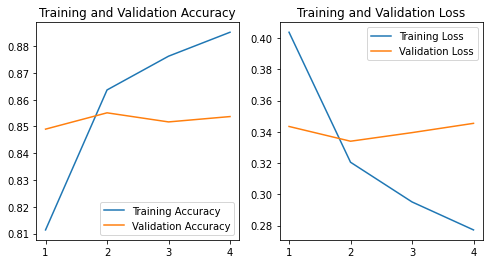

In [17]:
# Accuracy, Loss 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### B. GlobalMaxPooling1D 한 개의 레이어만 사용한 모델

In [18]:
# GlobalMaxPooling1D 모델 구성

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


In [19]:
# GlobalMaxPooling1D 모델 학습

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=64,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
2128/2128 [==============================] - 8s 3ms/step - loss: 0.5615 - accuracy: 0.7175 - val_loss: 0.3912 - val_accuracy: 0.8219
Epoch 2/5
2128/2128 [==============================] - 7s 3ms/step - loss: 0.3766 - accuracy: 0.8335 - val_loss: 0.3787 - val_accuracy: 0.8305
Epoch 3/5
2128/2128 [==============================] - 7s 3ms/step - loss: 0.3508 - accuracy: 0.8495 - val_loss: 0.3785 - val_accuracy: 0.8330
Epoch 4/5
2128/2128 [==============================] - 7s 3ms/step - loss: 0.3368 - accuracy: 0.8553 - val_loss: 0.3790 - val_accuracy: 0.8325
Epoch 5/5
2128/2128 [==============================] - 7s 3ms/step - loss: 0.3290 - accuracy: 0.8588 - val_loss: 0.3811 - val_accuracy: 0.8305


In [20]:
# GlobalMaxPooling1D 모델 평가

results = model.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3967 - accuracy: 0.8235
[0.39671212434768677, 0.8235246539115906]


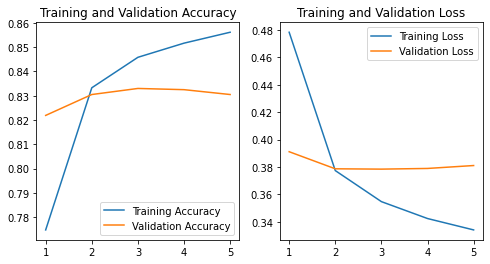

In [21]:
# Accuracy, Loss 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### C. LSTM 레이어

In [22]:
# LSTM 레이어 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))  #LSTM state 벡터의 차원수
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  #최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 40,497
Trainable params: 40,497
Non-trainable params: 0
_________________________________________________________________


In [23]:
# LSTM 레이어 모델 학습

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=64,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
2128/2128 [==============================] - 22s 9ms/step - loss: 0.5488 - accuracy: 0.6823 - val_loss: 0.3482 - val_accuracy: 0.8483
Epoch 2/5
2128/2128 [==============================] - 19s 9ms/step - loss: 0.3327 - accuracy: 0.8570 - val_loss: 0.3378 - val_accuracy: 0.8519
Epoch 3/5
2128/2128 [==============================] - 19s 9ms/step - loss: 0.3115 - accuracy: 0.8680 - val_loss: 0.3451 - val_accuracy: 0.8530
Epoch 4/5
2128/2128 [==============================] - 20s 9ms/step - loss: 0.3013 - accuracy: 0.8720 - val_loss: 0.3414 - val_accuracy: 0.8530
Epoch 5/5
2128/2128 [==============================] - 19s 9ms/step - loss: 0.2870 - accuracy: 0.8780 - val_loss: 0.3381 - val_accuracy: 0.8516


In [24]:
# LSTM 모델 평가

results = model.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3488 - accuracy: 0.8447
[0.34879791736602783, 0.8447220325469971]


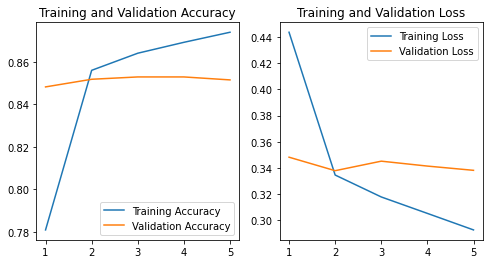

In [25]:
# Accuracy, Loss 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## ✨ 학습된 Embedding Layer 분석 ✨

- 우선, 필요한 라이브러리를 import 한 뒤 작업을 수행한다.

In [26]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

# 임베딩 레이어 차원 확인
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # 출력 형태 : (vocab_size, embedding_dim)

(10000, 4)


In [27]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 기록

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [28]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
# 파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

# 유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("사랑")

[('브금', 0.9996980428695679),
 ('긴말', 0.9994784593582153),
 ('쿨', 0.9994405508041382),
 ('시원', 0.9990736246109009),
 ('에선', 0.9986582398414612),
 ('닮', 0.9986392259597778),
 ('으신', 0.9986221790313721),
 ('세우', 0.9983918070793152),
 ('는다는', 0.9980425834655762),
 ('놀란', 0.9979112148284912)]

- 위의 결과로 보아, 기존의 영어로 된 Word2Vec으로는 **사랑을 키워드로 한 비슷한 의미를 갖는 단어를 찾기 어렵다.**
- Exploration 노드에서는 한국어 버전의 Word2Vec를 활용할 수 있도록 준비되어 있다. 이제, 이 데이터를 사용해 성능을 올려볼 것이다.

## ✨ 한국어 버전 Word2Vec Embedding 활용하기 ✨

- 먼저 gensim 패키지의 버전을 확인하자. (2021.08.17 내용 수정)
- 프로젝트 수행 과정에서 gensim 패키지의 버전을 다운그레이드하였다. 이유는 한국어 Word2Vec 파일을 잘 불러오지 못하는 문제 때문이었다.
- pip install --upgrade gensim==3.8.3 명령어를 Cloud Shell에 입력해 주어 한국어 파일인 ko_model을 정상적으로 불러올 수 있었다.
- Word2Vec을 통해 모델의 성능을 개선하기 위한 기초 단계부터 시작해보자.

In [29]:
# gensim 패키지 버전 알아보기

import gensim
gensim.__version__

'3.8.3'

In [30]:
# 한국어 Word2Vec 파일 불러와 ko_model에 저장하기

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
ko_model = gensim.models.Word2Vec.load(word2vec_path)

In [32]:
from gensim.models import KeyedVectors

# 유사한 단어와 그 유사도 확인
ko_model.wv.most_similar("사랑")

[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [33]:
ko_model['사랑'].shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(200,)

- **(2021.08. 17 수정) AIFFEL 포럼을 통해 일부 내용 수정** 🔧
1. 워드 벡터의 차원 수는 사전에 학습된 임베딩 레이어에 기반하므로 사람이 직접 설정하는 하이퍼 파라미터와는 거리가 있음
2. 따라서 하이퍼 파라미터로 언급한 부분을 삭제하고 내용을 수정함

In [35]:
vocab_size = 10000     # 단어 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim) # 사전학습된 임베딩 레이어의 차원 수 그대로 따라가는 것이 좋아요!

#embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 순서대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


- 이제 한국어 Word2Vec을 사용해서 이전의 세 가지 모델을 다시 학습시키고 평가한다.

### A. LSTM 레이어

In [47]:
model_lstm = keras.Sequential()

model_lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix), 
                                  input_length=maxlen, trainable=True)) # trainable을 True로 주면 Fine-tuning
model_lstm.add(keras.layers.LSTM(8))          
model_lstm.add(keras.layers.Dense(4, activation='relu'))
model_lstm.add(keras.layers.Dense(1, activation='sigmoid'))
         
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5         
Total params: 2,006,729
Trainable params: 2,006,729
Non-trainable params: 0
_________________________________________________________________


In [48]:
model_lstm.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs_lstm=5
history_lstm = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs_lstm,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1064/1064 [==============================] - 21s 18ms/step - loss: 0.6563 - accuracy: 0.5821 - val_loss: 0.4490 - val_accuracy: 0.8298
Epoch 2/5
1064/1064 [==============================] - 19s 18ms/step - loss: 0.4149 - accuracy: 0.8433 - val_loss: 0.3740 - val_accuracy: 0.8500
Epoch 3/5
1064/1064 [==============================] - 19s 18ms/step - loss: 0.3378 - accuracy: 0.8706 - val_loss: 0.3517 - val_accuracy: 0.8560
Epoch 4/5
1064/1064 [==============================] - 18s 17ms/step - loss: 0.3001 - accuracy: 0.8838 - val_loss: 0.3524 - val_accuracy: 0.8558
Epoch 5/5
1064/1064 [==============================] - 19s 18ms/step - loss: 0.2748 - accuracy: 0.8958 - val_loss: 0.3431 - val_accuracy: 0.8576


In [49]:
results = model_lstm.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.3526 - accuracy: 0.8523
[0.35260555148124695, 0.8523099422454834]


### B. 1-D CNN

In [50]:
model_cnn = keras.Sequential()

model_cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, trainable=True))
model_cnn.add(keras.layers.Conv1D(32, 3, activation='relu'))
model_cnn.add(keras.layers.MaxPooling1D(5))
model_cnn.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(8, activation='relu'))
model_cnn.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 39, 32)            19232     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 16)             1552      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [51]:
model_cnn.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs_cnn=5
history_cnn = model_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs_cnn,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1064/1064 [==============================] - 21s 17ms/step - loss: 0.5662 - accuracy: 0.6950 - val_loss: 0.3804 - val_accuracy: 0.8316
Epoch 2/5
1064/1064 [==============================] - 16s 15ms/step - loss: 0.3463 - accuracy: 0.8485 - val_loss: 0.3388 - val_accuracy: 0.8510
Epoch 3/5
1064/1064 [==============================] - 16s 15ms/step - loss: 0.2968 - accuracy: 0.8758 - val_loss: 0.3392 - val_accuracy: 0.8511
Epoch 4/5
1064/1064 [==============================] - 17s 16ms/step - loss: 0.2665 - accuracy: 0.8911 - val_loss: 0.3448 - val_accuracy: 0.8493
Epoch 5/5
1064/1064 [==============================] - 14s 13ms/step - loss: 0.2387 - accuracy: 0.9037 - val_loss: 0.3499 - val_accuracy: 0.8537


In [52]:
results2 = model_cnn.evaluate(x_test, y_test, verbose=2)

print(results2)

1537/1537 - 3s - loss: 0.3629 - accuracy: 0.8519
[0.3629055917263031, 0.851862370967865]


### C. GlobalMaxPooling1D 한 개의 레이어만 사용한 모델

In [71]:
model_gmp = keras.Sequential()

model_gmp.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, trainable=True))
model_gmp.add(keras.layers.GlobalMaxPooling1D())
model_gmp.add(keras.layers.Dense(8, activation='relu'))
model_gmp.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_gmp.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 200)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [73]:
model_gmp.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs_gmp=10
history_gmp = model_gmp.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs_gmp,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
2128/2128 [==============================] - 19s 9ms/step - loss: 0.4993 - accuracy: 0.7569 - val_loss: 0.4342 - val_accuracy: 0.7963
Epoch 2/10
2128/2128 [==============================] - 19s 9ms/step - loss: 0.4078 - accuracy: 0.8149 - val_loss: 0.3994 - val_accuracy: 0.8168
Epoch 3/10
2128/2128 [==============================] - 23s 11ms/step - loss: 0.3686 - accuracy: 0.8375 - val_loss: 0.3844 - val_accuracy: 0.8250
Epoch 4/10
2128/2128 [==============================] - 23s 11ms/step - loss: 0.3388 - accuracy: 0.8528 - val_loss: 0.3770 - val_accuracy: 0.8314
Epoch 5/10
2128/2128 [==============================] - 23s 11ms/step - loss: 0.3089 - accuracy: 0.8693 - val_loss: 0.4098 - val_accuracy: 0.8218
Epoch 6/10
2128/2128 [==============================] - 22s 10ms/step - loss: 0.2898 - accuracy: 0.8782 - val_loss: 0.3829 - val_accuracy: 0.8323
Epoch 7/10
2128/2128 [==============================] - 23s 11ms/step - loss: 0.2657 - accuracy: 0.8903 - val_loss: 0.3820 - v

In [74]:
results3 = model_gmp.evaluate(x_test, y_test, verbose=2)

print(results3)

1537/1537 - 3s - loss: 0.4286 - accuracy: 0.8292
[0.42858853936195374, 0.8292409777641296]


## 🔔 프로젝트 수행 결과 🔔

### 학습 및 평가, 시각화에 사용한 3개 모델에 대한 한국어 Word2Vec 임베딩 유무에 따른 Accuracy는 다음과 같다.
1. **1-D CNN** : 한국어 Word2Vec 임베딩 전 84.85% / 임베딩 후 85.19%
2. **LSTM 레이어** : 한국어 Word2Vec 임베딩 전 84.47% / 임베딩 후 85.23%
3. **GlobalMaxPooling1D** : 한국어 Word2Vec 임베딩 전 82.35% / 임베딩 후 82.92%

## 🚩 프로젝트 루브릭 자가평가 🚩

### 아래 프로젝트 목표에 대하여 자가평가한다. (루브릭 연계)

1. 3가지 이상의 모델을 활용하여 Text Classification Task를 구현할 수 있다.
2. gensim의 유사단어 찾기를 활용하여 자체 혹은 사전 학습된 임베딩 레이어를 분석할 수 있다.
3. 한국어 Word2Vec을 활용하여 감성분석의 validation 정확도 85% 이상이 되도록 설정할 수 있다.

### 자가평가 결과
1. 프로젝트 수행 결과에서 3가지 모델이 명시되어 있고, 임베딩 전후의 Accuracy까지 정상적으로 출력되었으므로 구현에 성공했다고 보았다.
2. 프로젝트 수행 초반 gensim의 버전에 대한 이슈로 한때 에러로 인해 어려움이 있었지만, 무사히 유사도 확인까지 마무리되었다.
3. 명시된 세 모델 중 **1-D CNN 모델과 LSTM 모델은 루브릭 기준인 85% 이상의 정확도를 나타냈다.** 반면 **GlobalMaxPooling1D는 82% 후반의 정확도를 나타내며 세 모델 중 루브릭 기준을 유일하게 넘어가지 못했다.**
4. GlobalMaxPooling1D의 경우 relu 부분과 epoch 등을 계속 조절하여 모델을 학습시키고 평가했지만, 85% 이상 결과는 아쉽게도 만들어내지 못했다.
5. 다만, **세 모델 모두 한국어 Word2Vec 임베딩을 적용하지 않았을 때보다 적용했을 때 소폭의 성능 향상이 이루어졌다는 점**은 뚜렷하게 나타났다.

## ⚓ 이번 탐험을 마치며 ⚓

- 이번 탐험은 텍스트 데이터를 처리하는 NLP 영역의 Exploration으로 gensim 버전 이슈, 데이터 로드 에러 등 다양한 시행착오를 겪어내어 결국 정확도에 관계없이 성능 평가에 사용된 세 모델 모두 한국어 Word2Vec 임베딩 이후 성능 개선을 이뤄냈다는 점이 탐험 과정에서 가장 기억에 남았던 것 같습니다.
- CV도 어렵지만 NLP도 만만치 않은 분야라는 것을 알게 되었습니다. 향후 다양한 프로젝트를 진행하면서 나에게 흥미와 동기를 유발시켜 프로젝트 과정을 잘 즐길 수 있을 것이라고 생각하는 분야를 선택할 수 있도록 앞으로의 프로젝트도 최선을 다해야 할 것 같습니다.